# RPN
## Reference
* [Faster R-CNN: Towards Real-Time Object
Detection with Region Proposal Networks](https://arxiv.org/pdf/1506.01497.pdf)

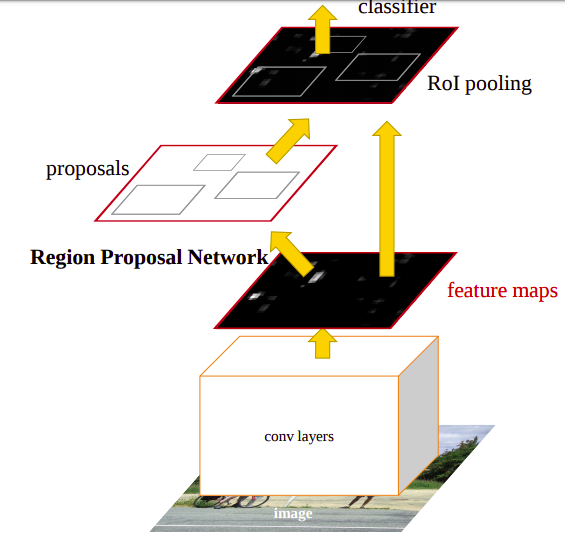

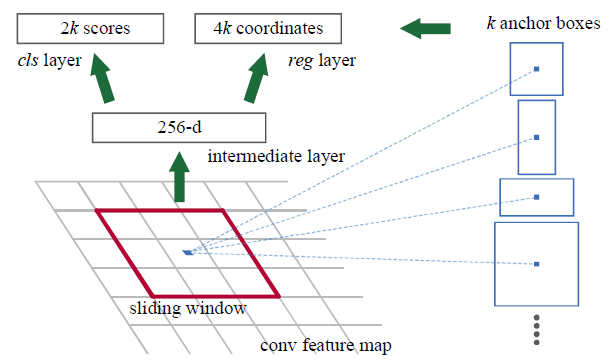

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

In [3]:
def idnetity_block(input_tensor, n_filter: list):
  F1, F2, F3 = n_filter
  # 1x1 conv layer
  x = layers.BatchNormalization()(input_tensor)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # 3x3 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F2, kernel_size=(3, 3), strides=1, padding='same')(x)

  # 1x1 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # shortcut connection
  x = layers.add([x, input_tensor])
  return x

In [4]:
def conv_block(input_tensor, n_filter: list):
  F1, F2, F3 = n_filter
  # 1x1 conv layer
  x = layers.BatchNormalization()(input_tensor)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=2, padding='valid')(x)

  # 3x3 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F2, kernel_size=(3, 3), strides=1, padding='same')(x)

  # 1x1 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # shortcut connection
  skip = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=2, padding='valid')(input_tensor)
  x = layers.add([x, skip])

  return x

In [5]:
def backbone(x):
  # 1st stage
  x = layers.ZeroPadding2D(padding=(3, 3))(X)
  x = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')(x)

  # 2nd stage
  x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x) # (56, 56, 64)
  x = conv_block(x, [64, 64, 256])
  x = idnetity_block(x, [64, 64, 256])
  x = idnetity_block(x, [64, 64, 256])

  # 3rd stage
  x = conv_block(x, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])

  # 4th stage
  x = conv_block(x, [256, 256, 1024])
  for i in range(22):
    x = idnetity_block(x, [256, 256, 1024])

  # 5th stage
  x = conv_block(C4, [512, 512, 2048])
  x = idnetity_block(x, [512, 512, 2048])
  x = idnetity_block(x, [512, 512, 2048])

  return x

In [6]:
def rpn(input_tensor):
  # x = layers.Input(shape=(None, None, 256))
  x = layers.Conv2D(kernel=256, kernel_size=3, padding='valid', activaion='relu')(input_tensor)
  cls = layers.Conv2D(kernel=num_anchor, kernel_size=1, padding='valid', activaion='sigmoid')(x)
  reg = layers.Conv2D(kernel=num_anchor*4, kernel_size=1, padding='valid', activaion='linear')(x)
  return cls, reg

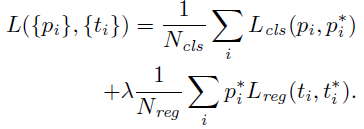

Regression loss is smoothed L1 function defined in [Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf)

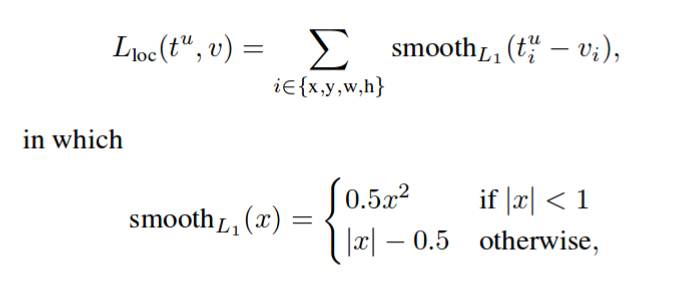

In [7]:
def smooth_func(x):
  x = tf.abs(x)
  compare = tf.ones((num_anchor, x))
  out = tf.where(tf.less(x, compare), tf.pow(x, 2)*0.5, x-0.5)
  return out

def smooth_L1(preds, truth):
  diff = truth - preds
  out = tf.map_fn(smooth_func, diff)
  return out

In [8]:
def rpn_loss(cls_preds, cls_truth, bbox_preds, bbox_truth):
  Lambda = 1e+3
  cls_loss = (cls_truth * tf.math.log(cls_preds) - (1 - cls_truth) * tf.math.log(1 - cls_preds)) / num_anchor
  reg_loss = smooth_L1(bbox_preds, bbox_truth)
  out = cls_loss + reg_loss * Lambda
  return out